<a href="https://colab.research.google.com/github/samuel1sm/Project_MPCE/blob/main/TestesFaceClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Preparação do ambiente*


In [143]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [144]:
!pip install face_recognition
!pip install networkx
# !pip install ISR
# !pip install chinese-whispers

In [145]:
 import shutil

!ln -s "/content/gdrive/My Drive/Datasets/ProjetoMPCE/TestDataset/Faces" imgs
if not os.path.exists("dataset"):
  os.mkdir("dataset")
  os.mkdir("dataset/training")
  os.mkdir("dataset/test")


!ln -s "/content/gdrive/My Drive/Datasets/ProjetoMPCE/Util" utils

!ln -s "/content/gdrive/MyDrive/Datasets/ProjetoMPCE/pretrained_models" /content/learn-to-cluster/data

shutil.rmtree('/imgs/Faces', ignore_errors=True)


ln: failed to create symbolic link 'imgs/Faces': File exists
ln: failed to create symbolic link 'utils/Util': File exists
ln: failed to create symbolic link '/content/learn-to-cluster/data': No such file or directory


In [146]:
data_sets = os.listdir("imgs/")
data_sets

['SortedImages.zip', 'data7.zip', 'Eu.zip', 'ImagesInstagram.zip', 'Faces']

In [147]:
training_datasets = ['ImagesInstagram.zip']
test_datasets = ["Eu.zip"]

In [148]:
from zipfile import ZipFile

In [149]:
for i in training_datasets:
  with ZipFile(f"imgs/{i}", 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall("dataset/training")

for i in test_datasets:
  with ZipFile(f"imgs/{i}", 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall("dataset/test")

In [150]:
import glob 
images_path = glob.glob("dataset/training/*")
images_path_test = glob.glob("dataset/test/*")


# *Codificando faces*




In [172]:
from imutils import paths
import face_recognition
import argparse
import pickle
import cv2
import os
from PIL import Image, ImageDraw
import numpy as np
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import dlib
from google.colab.patches import cv2_imshow
import pandas as pd
import sklearn
import sklearn.metrics as sm

In [173]:
print("[INFO] quantifying faces...")
imagePaths = images_path
detection_method = "cnn"
encondings_path = "encodings/"
data = []

if not os.path.exists(encondings_path):
  os.mkdir(encondings_path)

[INFO] quantifying faces...


In [197]:
def extract_face_features(images_path, normalize: bool = True , print_key: bool = True ) -> list:
  padding_perc = 0.2
  prediction = "utils/shape_predictor_68_face_landmarks.dat"
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor(prediction)
  fa = FaceAligner(predictor, desiredFaceWidth=256)

  data = []
  for (i, imagePath) in enumerate(images_path):
    if print_key:
      print(f"[INFO] processing {imagePath} , {i + 1}/{len(images_path)}")
      print(imagePath)

    image = cv2.imread(imagePath)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    boxes = face_recognition.face_locations(rgb,  model=detection_method)
    if len(boxes) == 0:
        continue

    if normalize:
      encodings = []
      rgbs = []
      final_boxes = []
      fa = FaceAligner(predictor)
      for i,box in enumerate(boxes):
        top, right, bottom, left = box
        rec = dlib.rectangle(top = top, right = right, bottom = bottom, left = left)
        faceAligned = fa.align(image, gray, rec)
        faceAligned = cv2.cvtColor(faceAligned, cv2.COLOR_BGR2RGB)
        # faceAligned = imutils.resize(faceAligned, width= right - left, height= bottom - top)
        # cv2_imshow(sr_img)
        # cv2_imshow(a)

        encodings.extend( face_recognition.face_encodings(faceAligned,[(0, 256,256,0)] ))
    else:
        encodings = face_recognition.face_encodings(rgb,boxes)



    d = [{"imagePath": imagePath, "loc": box, "encoding": enc} 
        for (box, enc) in zip(boxes, encodings)]

    data.extend(d)
  data = pd.DataFrame(data)
  data.index += 1 
  return data

In [198]:

a = ["dataset/85.jpg"]
a = images_path
data = extract_face_features(a,normalize= True, print_key = False)


In [196]:
data

imagePath  ...                                           encoding
1  dataset/training/41.jpg  ...  [-0.01457721646875143, 0.0919417291879654, 0.0...

[1 rows x 3 columns]

In [176]:
# data_test = extract_face_features(images_path_test,normalize= True, print_key = False)
# data_test.index += 1 

In [177]:
print(len(data))
print("[INFO] serializing encodings...")
f = open(f"data.pickle", "wb")
f.write(pickle.dumps(data))
f.close()

1
[INFO] serializing encodings...


# *Gerar Grafo*


In [199]:
import pandas as pd
import networkx as nx
import numpy as np
import dlib
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN,KMeans
from imutils import build_montages
import numpy as np
import argparse
import pickle
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import dlib 

In [200]:
def generate_conections(encodings,threshold:float = 0.5 ,euclidean: bool = True):
  faces_data_graph = {"node_x" : [], "node_y" : [],  "value" : []}
  # threshold = 0.5
  for i,line in encodings.iterrows():
    for j,line2 in encodings.iterrows():
        if euclidean:
          dist = np.linalg.norm(line['encoding']-line2['encoding'])

          if threshold > dist:
            faces_data_graph["node_x"].append(i)
            faces_data_graph["node_y"].append(j)
            faces_data_graph["value"].append(dist)
        else:
          dist = 1 - sm.pairwise.cosine_similarity([line['encoding']], [line2['encoding']], dense_output=True)[0][0]
          # dist = int(dist) if dist > 1 or dist < 0 else dist

          faces_data_graph["node_x"].append(i)
          faces_data_graph["node_y"].append(j)
          faces_data_graph["value"].append(dist)

  return pd.DataFrame(faces_data_graph)

In [201]:
def plot_graph_clustering(G,clusters_data: pd.DataFrame = None, attribute : str = "value", ):
  edge_label = get_graph_edges_value(G, attribute)
  pos=nx.spring_layout(G)

  if type(clusters_data) == pd.DataFrame:
    clusters_data['labels']=pd.Categorical(clusters_data['labels'])

    nx.draw(G, with_labels=True,pos=pos, node_color=clusters_data['labels'].cat.codes, cmap=plt.cm.Set1, node_size=500)
  else:
    nx.draw(G,pos ,with_labels=True)

  a = nx.draw_networkx_edge_labels(G,pos = pos,edge_labels=edge_label,font_color='red')
  plt.show()

In [202]:
def get_graph_edges_value(G , attribute: str = "value"):
  return nx.get_edge_attributes(G,attribute)

In [203]:
def create_graph(graph_data, plot_graph : bool = False, source: str = "node_x", target: str = "node_y", edge_attr=["value"],attribute: str = "value"  ):
  if not type(graph_data) == pd.DataFrame:
    graph_data = pd.DataFrame(graph_data)

  G = nx.from_pandas_edgelist(graph_data, source=source, target = target, edge_attr=edge_attr )
  if plot_graph:
    plot_graph_clustering(G, attribute = attribute)
  
  return G

In [204]:
def cluster_cw(G):
  edge_label = get_graph_edges_value(G)
  chinise_whipers_list = [(k[0], k[1], edge_label[k]) for k in edge_label]
  clusters = dlib.chinese_whispers(chinise_whipers_list)

  results_df = pd.DataFrame()
  results_df['ID'] = range(len(G)+1)
  results_df['labels'] = clusters
  results_df = results_df.set_index('ID')
  results_df = results_df.reindex(G.nodes())
  labels = np.unique(results_df['labels'])
  results_df['labels']=pd.Categorical(results_df['labels'])

  for i in G.nodes():
    G.nodes()[i]["labels"] = results_df.loc[i]["labels"]
  
  return G,results_df

In [205]:
def add_new_faces(G, faces_dataframe :pd.DataFrame ,new_faces_dataframe : pd.DataFrame, threshold:float = 0.5):
  new_faces_dataframe.index += max(faces_dataframe.index)

  joined_data = pd.concat([faces_dataframe, test_encodings], ignore_index=False, sort=False)

  for i,line in new_faces_dataframe.iterrows():
    G.add_node(i)
    for j,line2 in faces_dataframe.iterrows():
      dist = np.linalg.norm(line['encoding']-line2['encoding'])
      if threshold > dist:
        G.add_edge(i, j, value = dist)

  return G,joined_data

In [206]:
faces_data_graph = generate_conections(data[["encoding"]],0.5, True)

In [207]:
G = create_graph(faces_data_graph, False)
G,results_df = cluster_cw(G)

In [208]:
# s_G, s_df = create_super_graph(G,results_df, False)
# plot_graph_clustering(G,results_df)
# print("-------------")

# s_G,s_results_df = cluster_cw(s_G)
# plot_graph_clustering(s_G,s_results_df)
# print("-------------")
# f_G,f_results_df = join_results(G, results_df, s_results_df)
# plot_graph_clustering(f_G,f_results_df)

In [209]:
df = pd.merge(data, results_df, left_index=True, right_index=True)
df.rename(columns = {"labels" : "cluster"}, inplace = True)
encodings =[dlib.vector(i) for i in df["encoding"].values.tolist()]

# *Clusterizando faces*


In [ ]:
from sklearn.cluster import DBSCAN,KMeans
from imutils import build_montages
import numpy as np
import argparse
import pickle
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import dlib 

In [ ]:
imagePaths = images_path
jobs = -1
detection_method = "cnn"

In [ ]:
print("[INFO] loading encodings...")
# data = pickle.loads(open(encondings_path, "rb").read())
df = pd.DataFrame(data)
encodings =[dlib.vector(i) for i in df["encoding"].values.tolist()]

[INFO] loading encodings...


In [ ]:
df

imagePath  ...                                           encoding
1     dataset/5.jpg  ...  [-0.0819849744439125, 0.13041013479232788, 0.0...
2    dataset/81.jpg  ...  [-0.07026118785142899, 0.20044054090976715, 0....
3    dataset/81.jpg  ...  [-0.12953229248523712, 0.01018319558352232, -0...
4    dataset/81.jpg  ...  [-0.18801122903823853, 0.043674495071172714, 0...
5    dataset/81.jpg  ...  [-0.11673849076032639, 0.08833518624305725, 0....
..              ...  ...                                                ...
234  dataset/80.jpg  ...  [-0.18139198422431946, 0.08926880359649658, 0....
235  dataset/80.jpg  ...  [-0.14539946615695953, 0.06612040102481842, 0....
236  dataset/80.jpg  ...  [-0.09730890393257141, 0.005383539013564587, 0...
237  dataset/80.jpg  ...  [-0.06233245134353638, 0.023112019523978233, -...
238   dataset/3.jpg  ...  [-0.20166118443012238, 0.08111695200204849, 0....

[238 rows x 3 columns]

In [ ]:
labels = dlib.chinese_whispers_clustering(encodings, 0.5)
df["cluster"] = labels

# Grafo teste


In [ ]:
def join_results(G, results_df, super_results_df):
  G = G.copy()
  p = s_results_df.reset_index()
  p.apply(lambda a: results_df["labels"].replace({a["ID"] : a["labels"]},inplace = True),axis = 1)

  for i in G.nodes():
    G.nodes()[i]["labels"] = results_df.loc[i]["labels"]
  
  return G,results_df

In [ ]:
def create_super_graph(G, results_df, plot_graph : bool = False):
  labels = results_df["labels"].unique().to_list()

  clusters_infos = {}
  df_nodes_in_clusters = results_df.reset_index().groupby("labels")

  for label in labels:
    sub_df = df_nodes_in_clusters.get_group(label)["ID"].to_list()
    gy = G.subgraph(sub_df)
    aux_df = pd.DataFrame(gy.edges(data=True))
    aux_df[2] = aux_df[2].apply(lambda a: a['value'])
    clusters_infos[label] = {"min" : min(aux_df[2]), "avg" : aux_df[2].mean()}
    edges_connection = {}

  for label in labels:
    cluster_nodes = df_nodes_in_clusters.get_group(label)["ID"].to_list()
    # print(cluster_nodes)
    for cn in cluster_nodes:
      # print(cn)
      for n in G.neighbors(cn):
        if n not in cluster_nodes:
          first_cluster = G.nodes()[cn]["labels"]
          second_cluster = G.nodes()[n]["labels"]

          tuple_key =  tuple(sorted([first_cluster , second_cluster]))
          nodes_connection = tuple(sorted([cn , n]))
          edge_value = G.get_edge_data(cn,n)['value']
          if not (edge_value >= clusters_infos[first_cluster]["min"] or edge_value >= clusters_infos[second_cluster]["min"]):
            continue
          if not tuple_key in edges_connection:
            edges_connection[tuple_key] = {"combinations" : [nodes_connection], "values" : [edge_value]}
          elif nodes_connection not in edges_connection[tuple_key]["combinations"] :
            edges_connection[tuple_key]["combinations"].append(nodes_connection)
            edges_connection[tuple_key]["values"].append(edge_value)

  super_graph_data = {"node_x" : [],"node_y" : [],"value" : [] }

  for i in labels:
    super_graph_data["node_x"].append(i)
    super_graph_data["node_y"].append(i)
    super_graph_data["value"].append(0)


  for key in edges_connection:
    node_sum = sum(edges_connection[key]['values'])  
    c1, c2 = key
    if node_sum >= clusters_infos[c1]["avg"] or node_sum >= clusters_infos[c2]["avg"]:
      super_graph_data["node_x"].append(c1)
      super_graph_data["node_y"].append(c2)
      super_graph_data["value"].append(max(edges_connection[key]['values']))
  
  print(super_graph_data)
  super_graph_data = pd.DataFrame(super_graph_data)
  return create_graph(super_graph_data, plot_graph), super_graph_data 

In [ ]:
c = {"node_x" : [1,1,1,1,2,2,4,4,6,13,13,13,15,15,12,12,11,11,11,11,9,9,9,7,7], 
     "node_y" : [2,3,4,5,3,4,5,6,5,12,15,14,12,14,14,11,8,10,7,9,8,10,7,8,10], 
     "value" : [0.6,0.1,0.35,0.2,0.28,0.1,0.6,0.25,0.2,0.6,0.4,0.3,0.4,0.35,0.5,0.2,0.5,0.1,0.6,0.5,0.4,0.3,0.4,0.2,0.2]}

c = pd.DataFrame(c)

{'node_x': [1, 2, 4, 3, 1], 'node_y': [1, 2, 4, 3, 2], 'value': [0, 0, 0, 0, 0.35]}


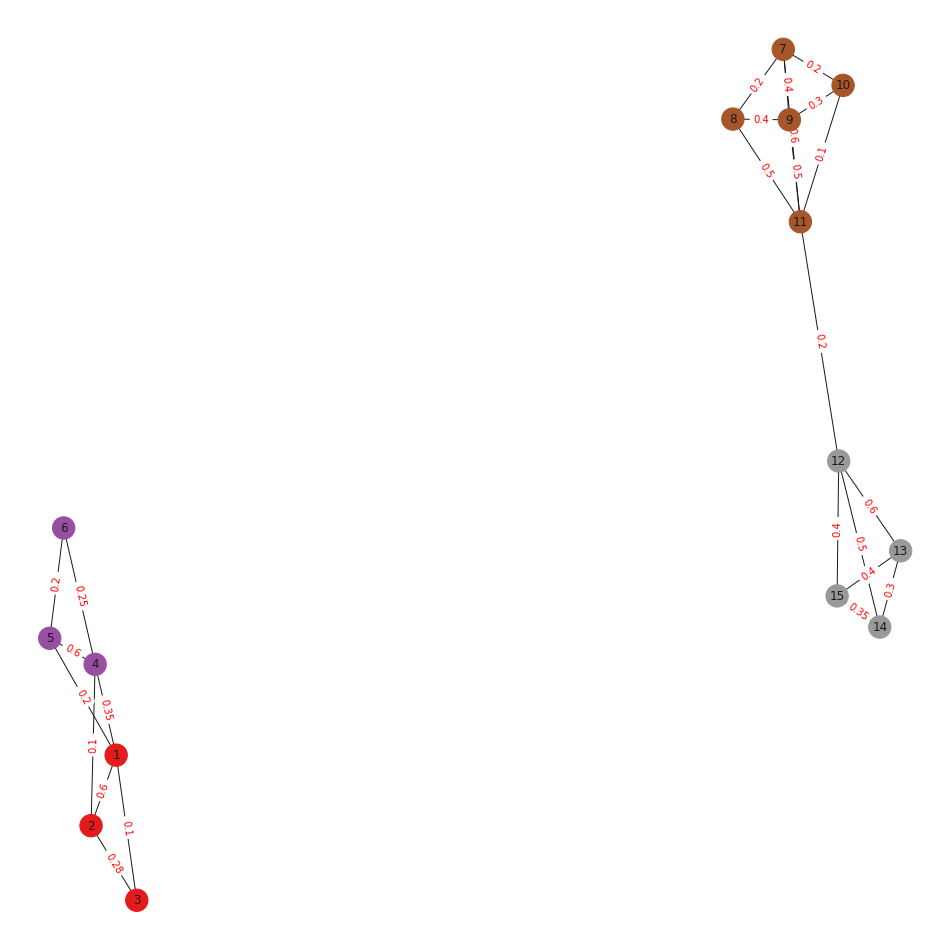

-------------


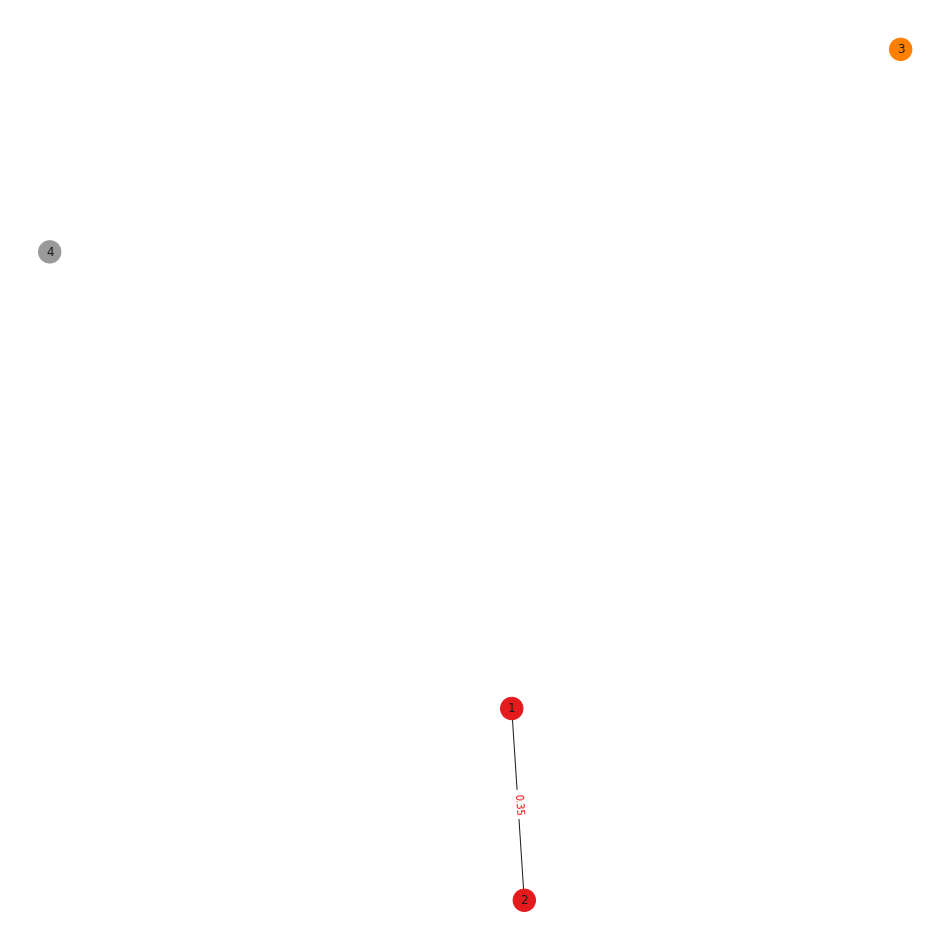

-------------


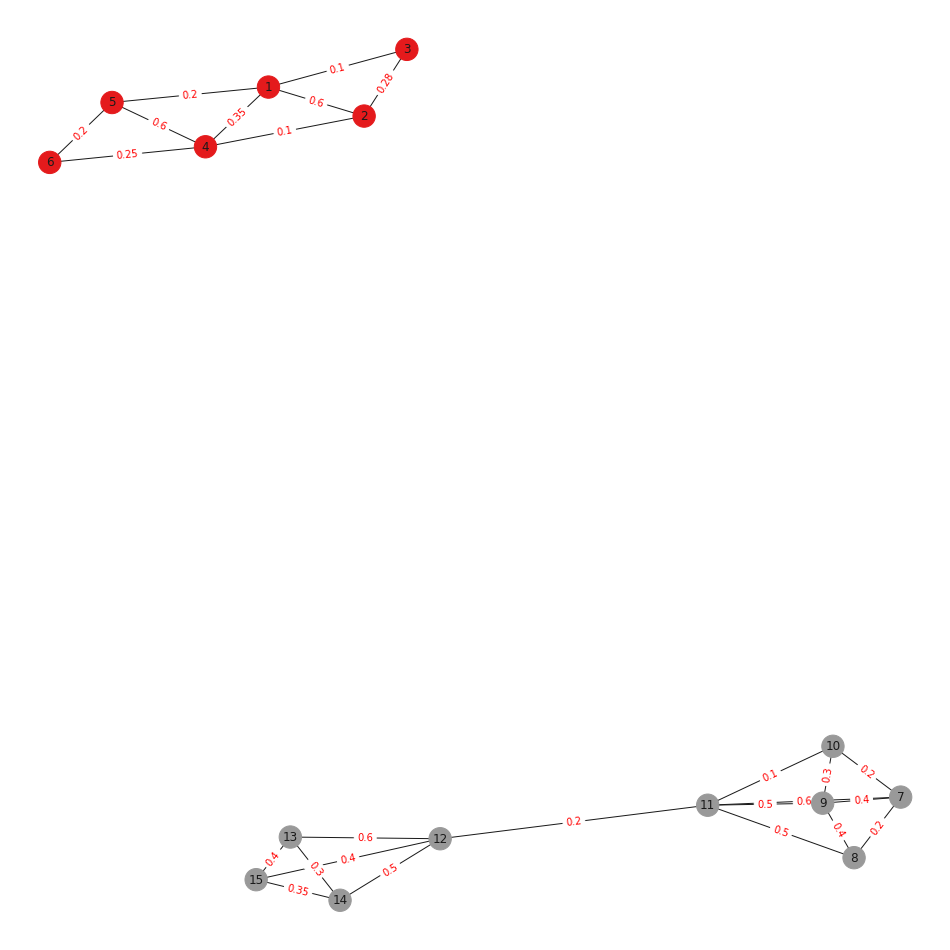

In [ ]:
G = create_graph(c, False)
G,results_df = cluster_cw(G)
# plot_graph_clustering(G,results_df)
s_G, s_df = create_super_graph(G,results_df, False)
plot_graph_clustering(G,results_df)
print("-------------")

s_G,s_results_df = cluster_cw(s_G)
plot_graph_clustering(s_G,s_results_df)
print("-------------")
f_G,f_results_df = join_results(G, results_df, s_results_df)
plot_graph_clustering(f_G,f_results_df)


# *Verificando Clusterização Imagens*


In [ ]:
qtd_cluster= len(df["cluster"].unique())
qtd_cluster

41

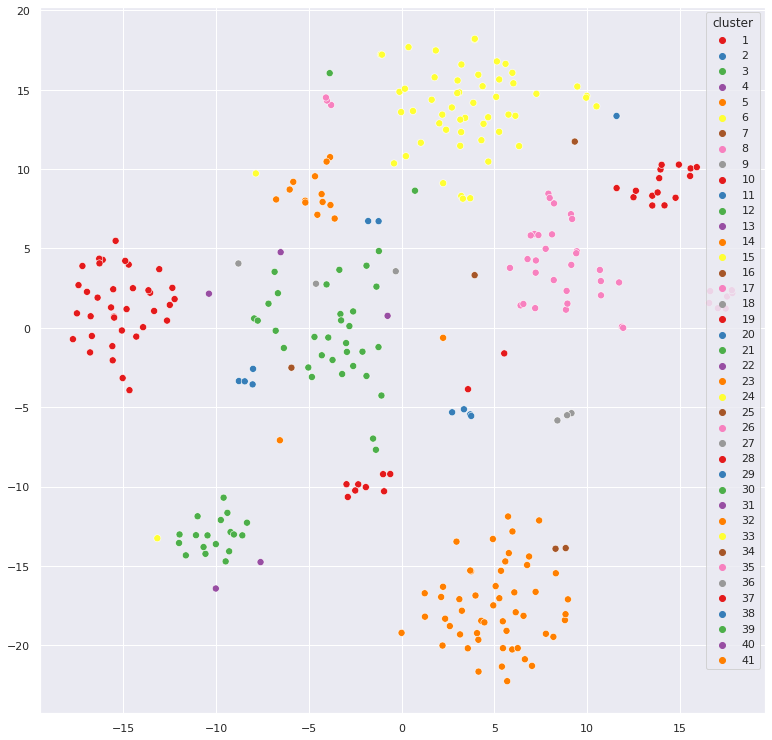

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE()
visualizacao = tsne.fit_transform(encodings)
import seaborn as sns

sns.set(rc={'figure.figsize': (13, 13)})
# sns.set_style("whitegrid", {'axes.grid' : False})
sns.scatterplot(x=visualizacao[:, 0],
               y=visualizacao[:, 1],
               hue=df["cluster"],
               palette=sns.color_palette('Set1',qtd_cluster), s = 50)

# *Gerar grafo*


In [ ]:
import networkx as nx

In [ ]:
# filtro = df.groupby(by="imagePath").apply(lambda a: a["cluster"].tolist())
graph_df = df.drop(columns = ["loc", "encoding"])
graph_df = graph_df.merge(graph_df, on = "imagePath")
graph_df = graph_df.query("cluster_x < cluster_y")
# filtro3 = filtro2.loc[filtro2[["cluster_x", "cluster_y"]].apply(lambda a: a["cluster_x"] != a["cluster_y"], axis = 1)]
graph_df.drop_duplicates(inplace= True)
# graph_df.query("cluster_x == 1").apply(lambda a: print(a["imagePath"],a["cluster_x"],a["cluster_y"]),axis =1)

In [ ]:
occurrences = graph_df.groupby(by="cluster_x").apply(lambda a:( a["cluster_y"].tolist()))

In [ ]:
graph_df = graph_df.sort_values(by=['cluster_x', 'cluster_y']).drop_duplicates(subset=['cluster_x', 'cluster_y']).reset_index(drop=True)

In [ ]:
result = []
for i,occurrence in enumerate(occurrences):
  fitered = np.unique(np.array(occurrence), return_counts = True)
  result.extend(fitered[1])

graph_df["occurrence"] = result

In [ ]:
self_pointg_df = {"imagePath" : [], "cluster_x" : [],"cluster_y" : [], "occurrence" : []}
for cluster in df["cluster"].unique():
  im_path = df[df["cluster"] == cluster]["imagePath"].values[0]
  self_pointg_df["imagePath"].append(im_path)
  self_pointg_df["cluster_x"].append(cluster)
  self_pointg_df["cluster_y"].append(cluster)
  self_pointg_df["occurrence"].append(1)

aux_df = pd.DataFrame(self_pointg_df)
graph_df = pd.concat([graph_df, aux_df])

In [ ]:
edge_label = {}
graph_df.apply(lambda a: edge_label.update({(a["cluster_x"],a["cluster_y"]) : a["occurrence"]}), axis = 1)

0     None
1     None
2     None
3     None
4     None
      ... 
40    None
41    None
42    None
43    None
44    None
Length: 200, dtype: object

In [ ]:
G = nx.from_pandas_edgelist(graph_df, source="cluster_x", target = "cluster_y", edge_attr=["occurrence"] )

In [ ]:
df_img_exemple = df.drop_duplicates("cluster").sort_values("cluster").reset_index(drop = True)

IndexError: ignored

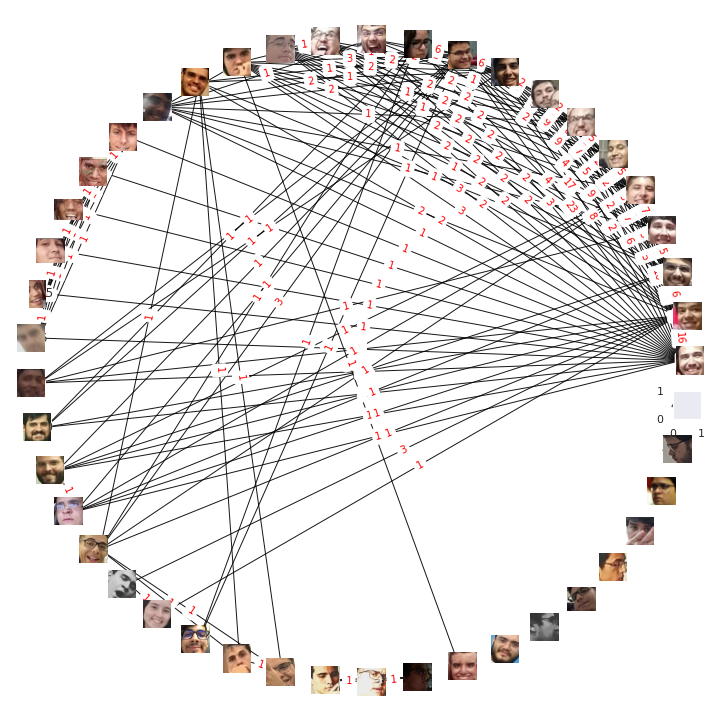

In [ ]:
fig=plt.figure(figsize=(13, 13))
ax=plt.subplot(111)
ax.set_aspect('equal')

pos=nx.circular_layout(G)

nx.draw(G,pos,edge_color='black',width=1,linewidths=1,\
node_size=1,node_color='pink',alpha=0.9,\
labels={node:node for node in G.nodes()}, ax =ax)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_label,font_color='red', ax = ax)


trans=ax.transData.transform
trans2=fig.transFigure.inverted().transform

piesize=0.03 # this is the image size
p2=piesize/2.0
for n in G:
    xx,yy=trans(pos[n]) # figure coordinates
    xa,ya=trans2((xx,yy)) # axes coordinates
    a = plt.axes([xa-p2,ya-p2, piesize, piesize])

    line = df_img_exemple.iloc[n]
    image = cv2.imread(line["imagePath"])
    (top, right, bottom, left) = line["loc"]
    face = image[top:bottom, left:right]
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)

    a.imshow(face)
    a.axis('off')

nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_label,font_color='red', ax = ax)

plt.axis('off')
plt.show()
print()

# *Plotando Imagens*


In [ ]:
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

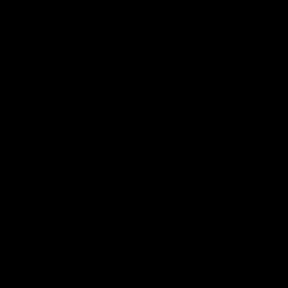

In [ ]:
filtro = df[df["imagePath"] == "dataset/65.jpg"]

filtro.reset_index(inplace=True)
faces = []
for i,line in filtro.iterrows():
    image = cv2.imread(line["imagePath"])
    (top, right, bottom, left) = line["loc"]
    face = image[top:bottom, left:right]
    face = cv2.resize(face, (96, 96))
    faces.append(face)
  
montage = build_montages(faces, (96, 96), (3, 3))[0]
cv2_imshow(montage)


In [ ]:
clusters_list = [6,5]
filtro = df[df["cluster"].isin(clusters_list)].copy()
filtro= filtro.groupby("imagePath").filter(lambda x: True if len(x["cluster"].unique()) == len(clusters_list) else False)
filtro = filtro.drop_duplicates(subset=['imagePath']).copy()
filtro.reset_index(inplace=True)
print(f"qtd: {len(filtro)}")
plt.figure(figsize=(8,14))
plt.rcParams["axes.grid"] = False

columns = 2
for i,line in filtro.iterrows():
      
    plt.subplot(((int(len(filtro)) +1)/columns),columns,i+1)
    img = cv2.imread(line["imagePath"])
    # cv2_imshow(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.title(line["imagePath"])
plt.show()

qtd: 0


<Figure size 576x1008 with 0 Axes>

51


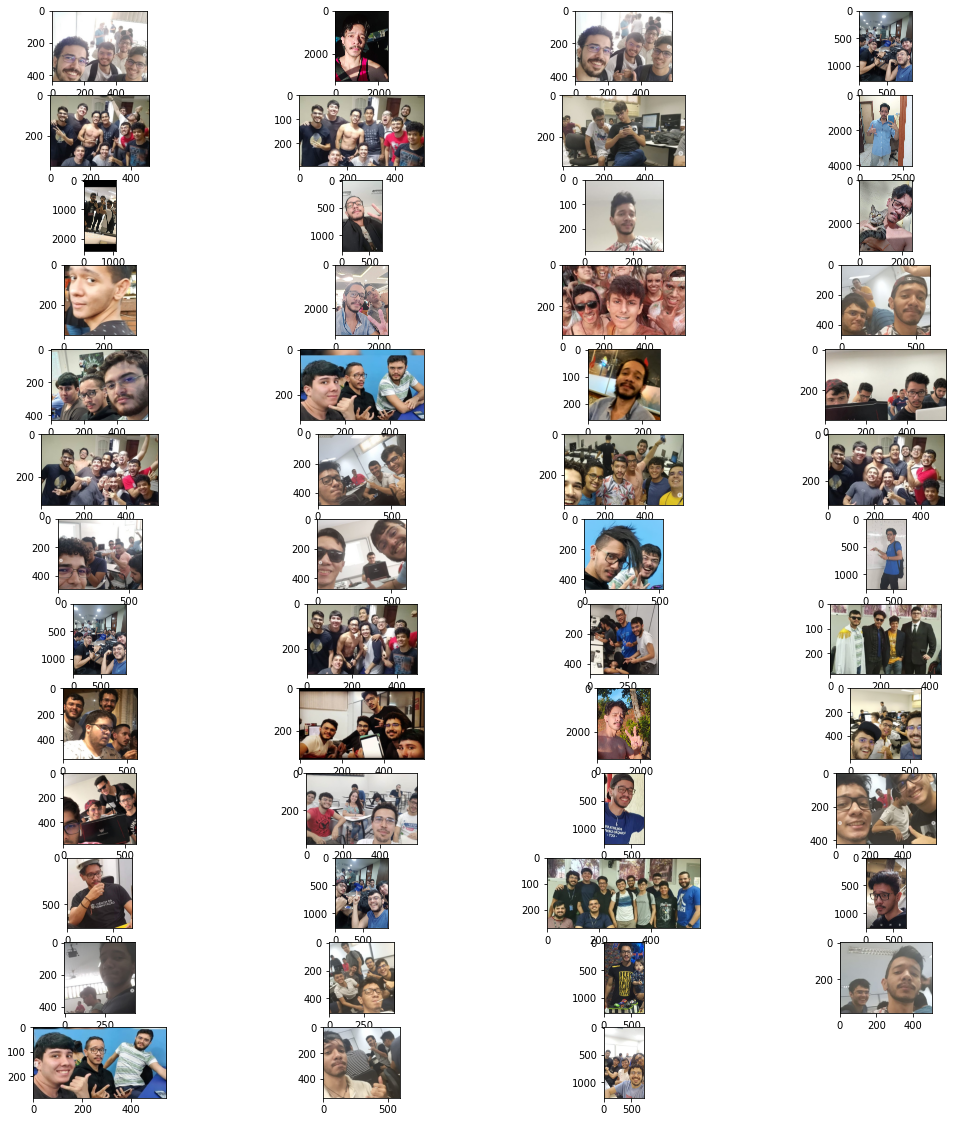

In [ ]:
filtro = df[df["cluster"] == 3].copy()

filtro.reset_index(inplace=True)
plt.figure(figsize=(18,20))
plt.rcParams["axes.grid"] = False

print(len(filtro))

columns = 4
for i,line in filtro.iterrows():
    
    plt.subplot(int(len(filtro)/columns)+1,columns,i+1)
    img = cv2.imread(line["imagePath"])
    # cv2_imshow(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()

[INFO] faces for face ID: 1, qtd = 36


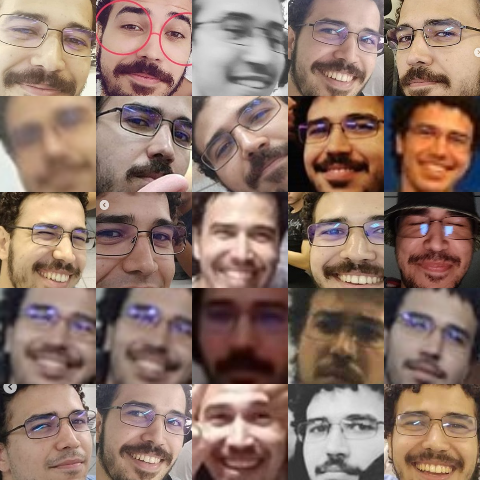

[INFO] faces for face ID: 2, qtd = 28


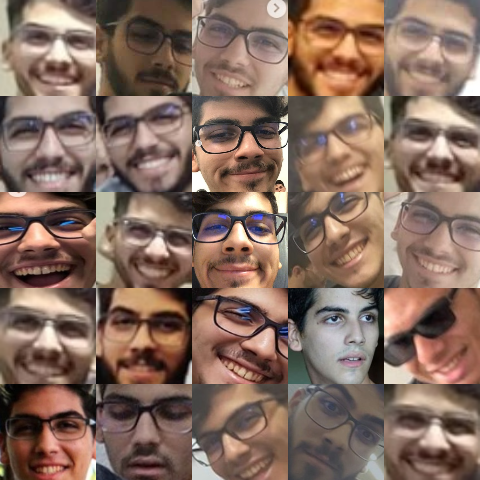

[INFO] faces for face ID: 3, qtd = 51


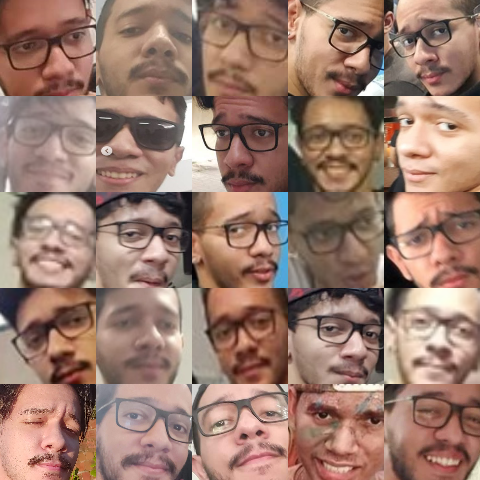

[INFO] faces for face ID: 4, qtd = 51


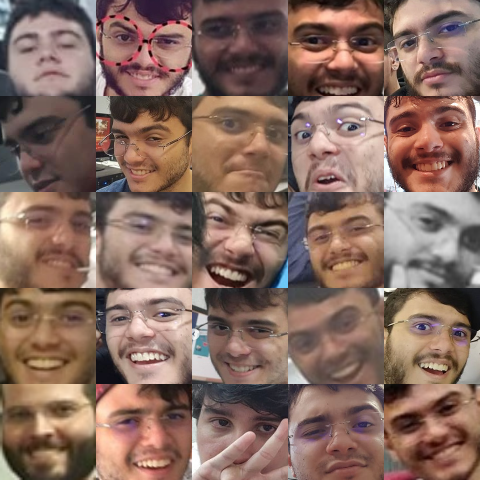

[INFO] faces for face ID: 5, qtd = 31


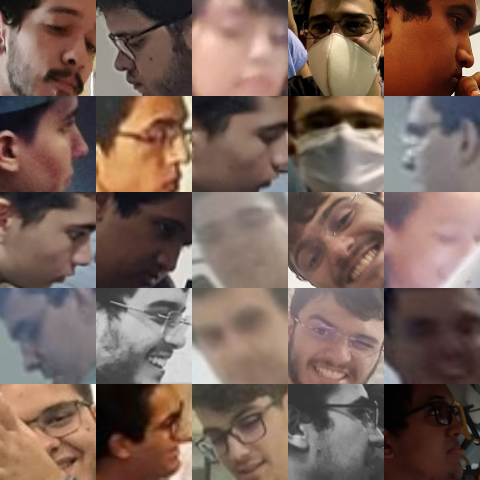

[INFO] faces for face ID: 6, qtd = 13


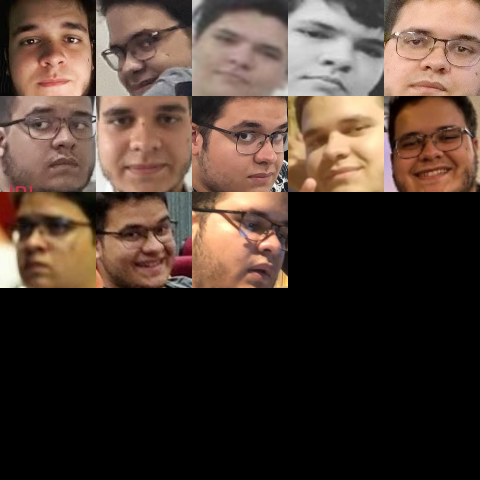

[INFO] faces for face ID: 7, qtd = 1


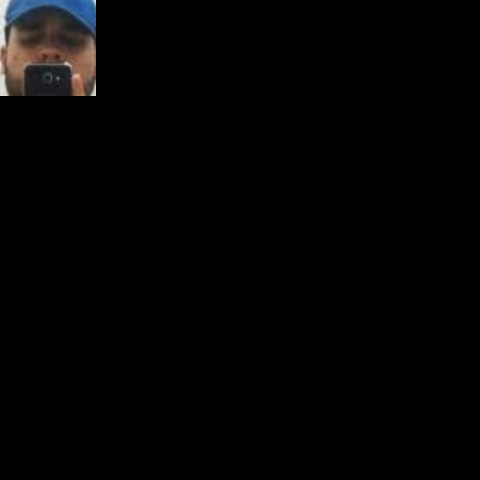

[INFO] faces for face ID: 8, qtd = 1


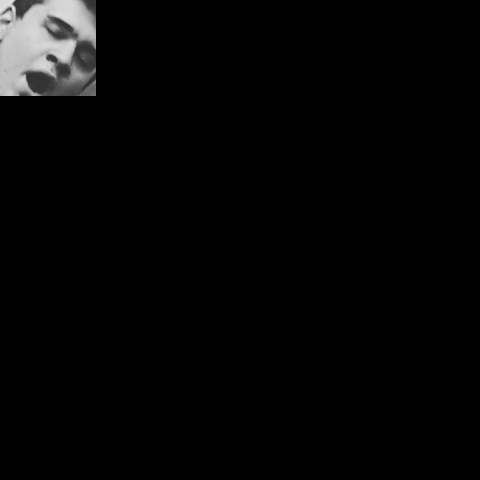

[INFO] faces for face ID: 9, qtd = 1


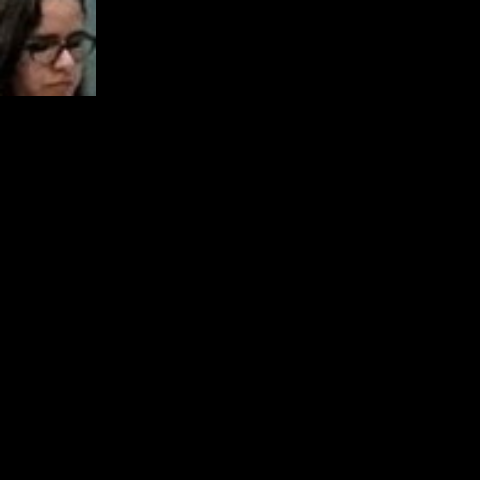

[INFO] faces for face ID: 10, qtd = 18


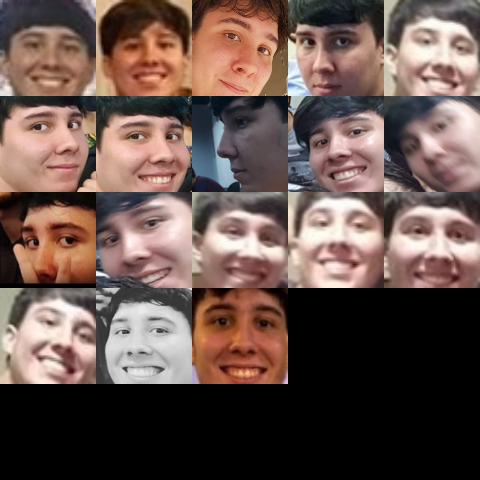

[INFO] faces for face ID: 11, qtd = 15


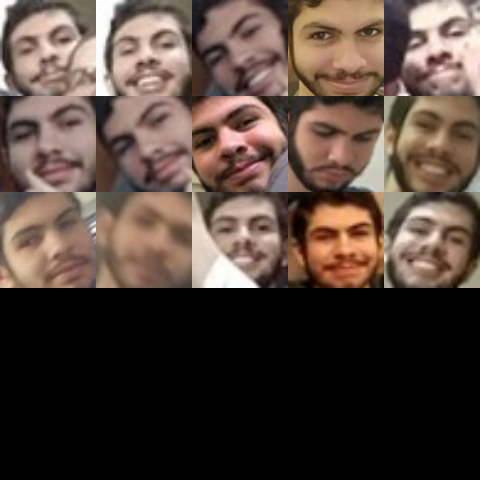

[INFO] faces for face ID: 12, qtd = 4


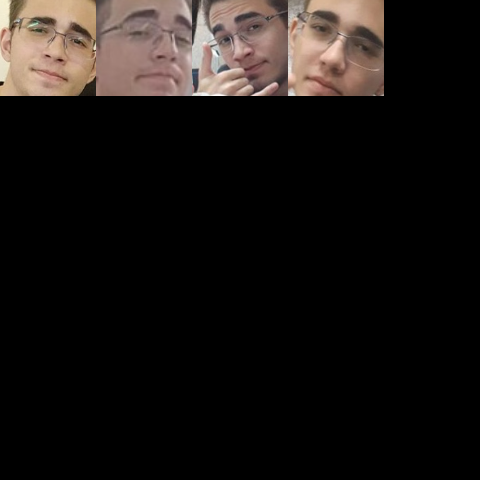

[INFO] faces for face ID: 13, qtd = 1


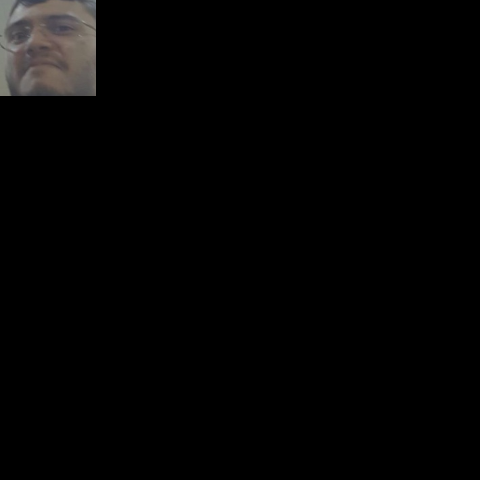

[INFO] faces for face ID: 14, qtd = 8


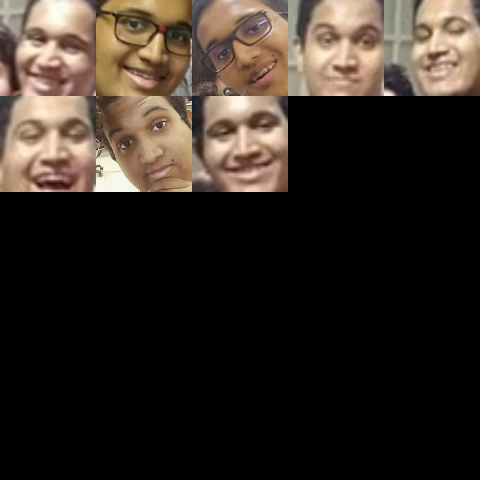

[INFO] faces for face ID: 15, qtd = 4


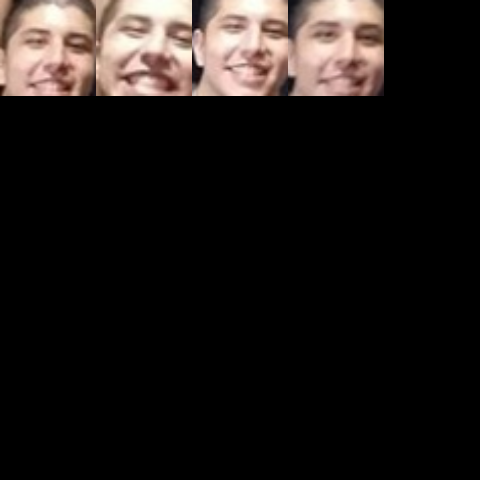

[INFO] faces for face ID: 16, qtd = 2


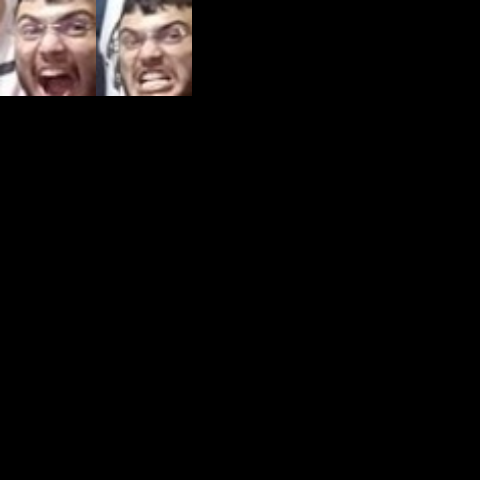

[INFO] faces for face ID: 17, qtd = 7


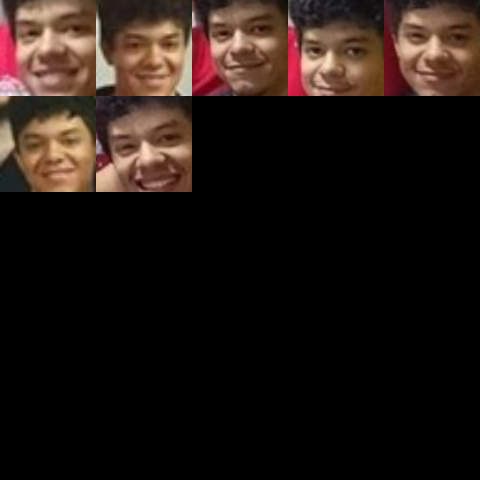

[INFO] faces for face ID: 18, qtd = 1


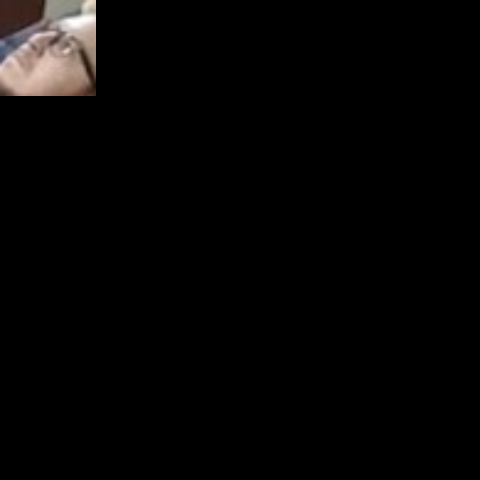

[INFO] faces for face ID: 19, qtd = 4


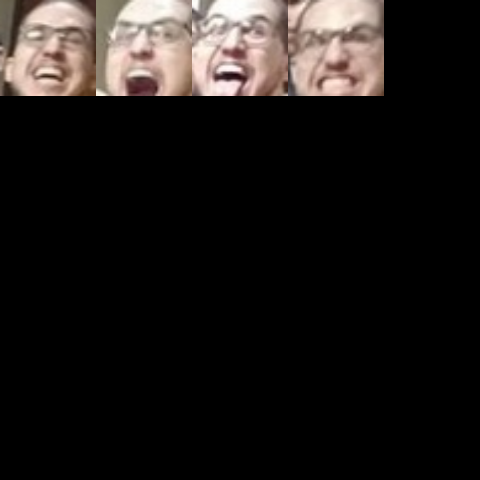

[INFO] faces for face ID: 20, qtd = 1


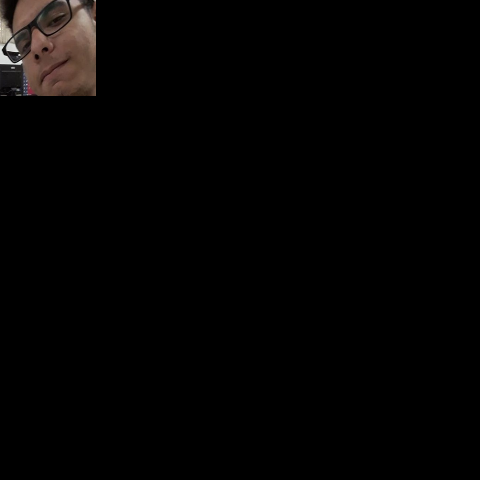

[INFO] faces for face ID: 21, qtd = 1


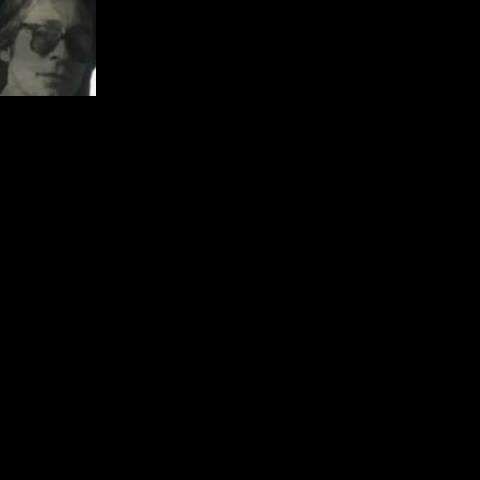

[INFO] faces for face ID: 22, qtd = 1


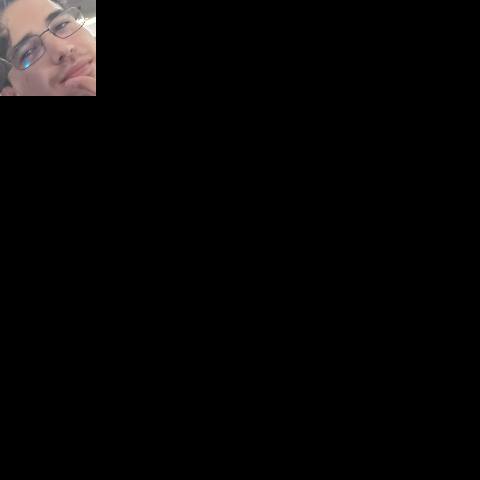

[INFO] faces for face ID: 23, qtd = 2


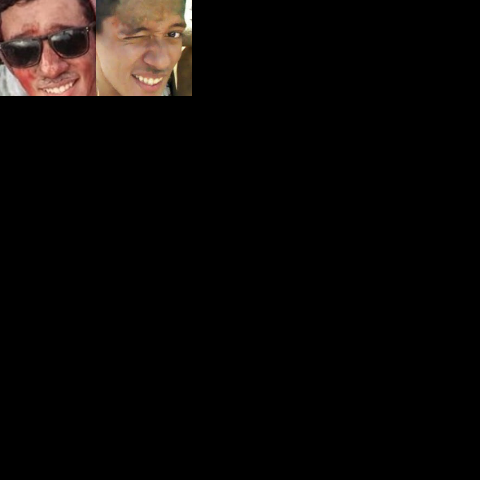

[INFO] faces for face ID: 24, qtd = 1


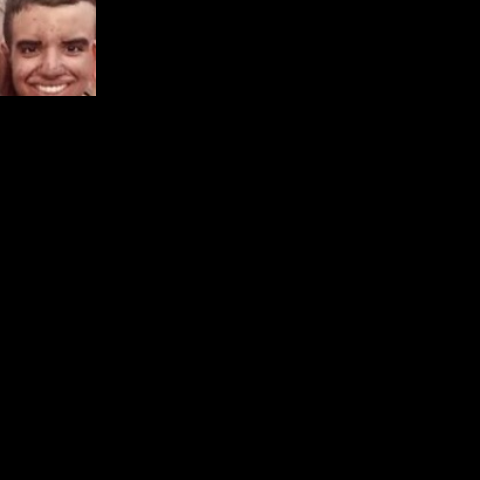

[INFO] faces for face ID: 25, qtd = 1


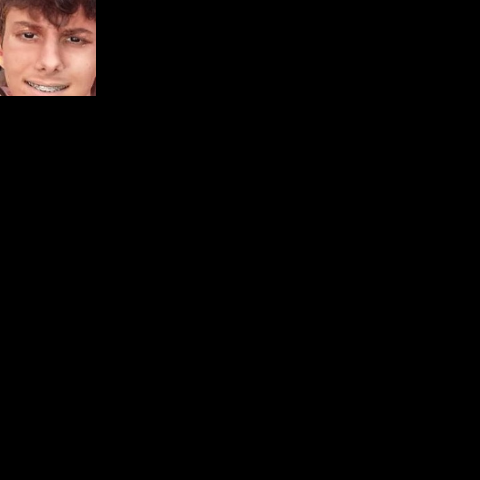

[INFO] faces for face ID: 26, qtd = 1


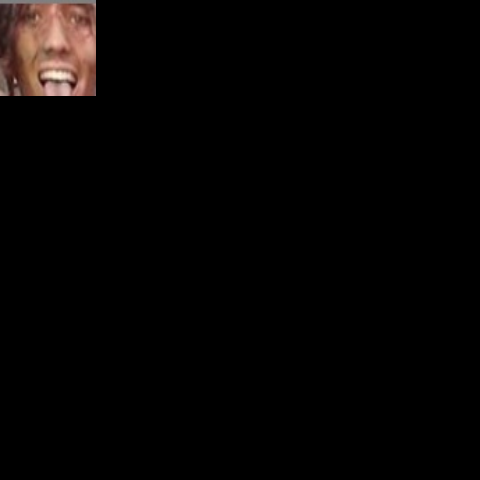

[INFO] faces for face ID: 27, qtd = 1


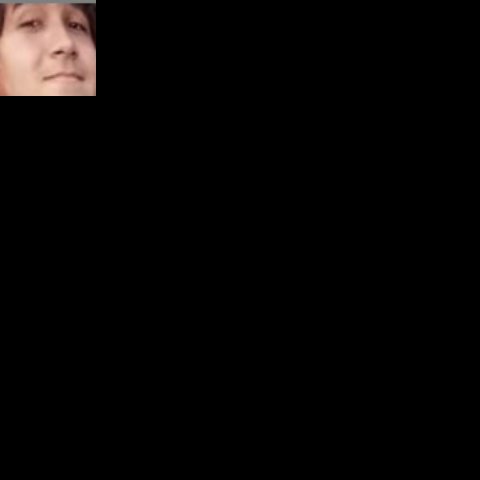

[INFO] faces for face ID: 28, qtd = 1


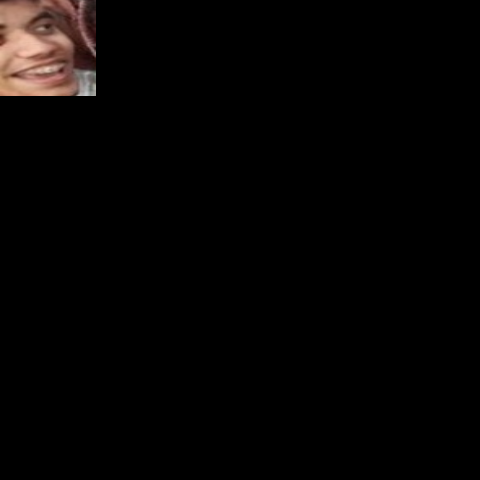

[INFO] faces for face ID: 29, qtd = 1


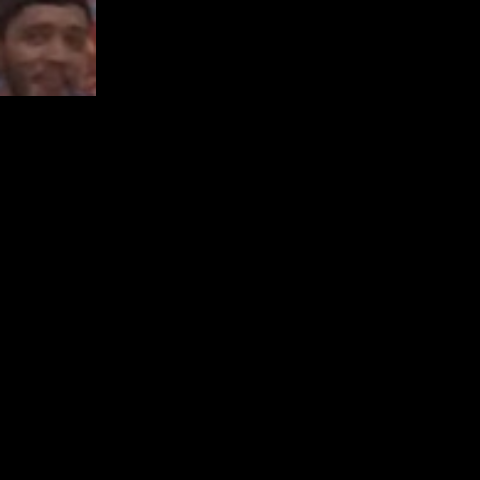

[INFO] faces for face ID: 30, qtd = 1


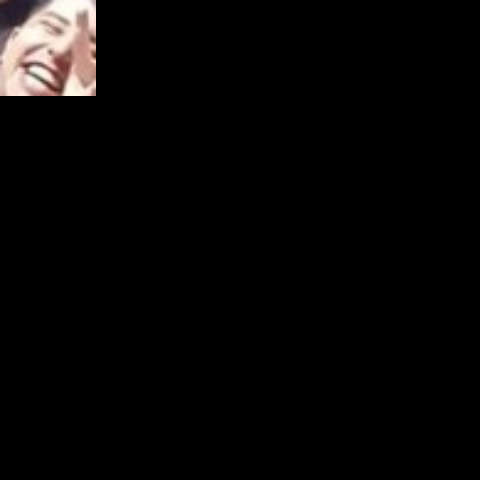

[INFO] faces for face ID: 31, qtd = 1


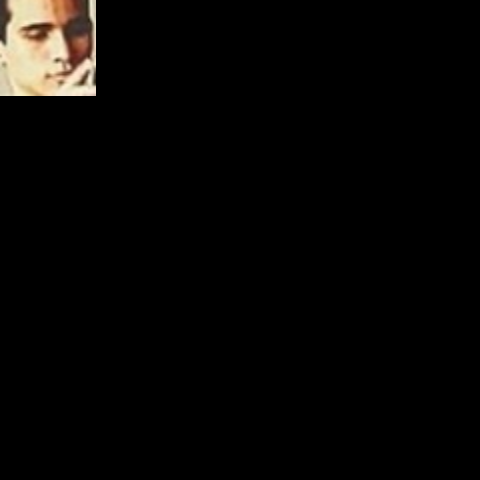

[INFO] faces for face ID: 32, qtd = 1


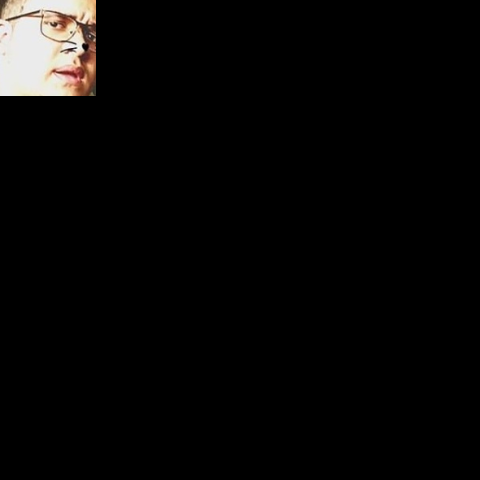

[INFO] faces for face ID: 33, qtd = 3


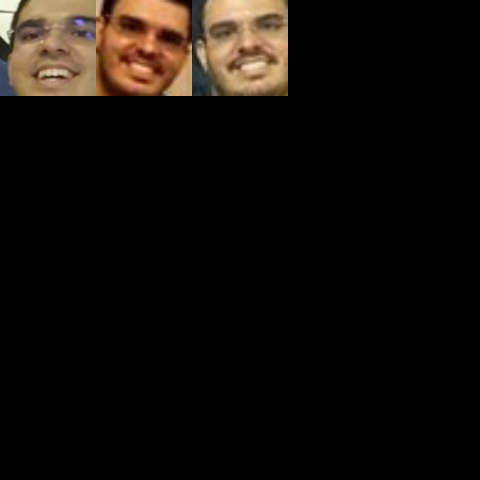

[INFO] faces for face ID: 34, qtd = 2


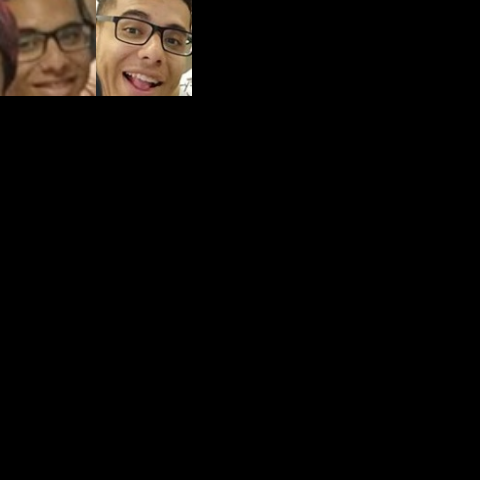

[INFO] faces for face ID: 35, qtd = 1


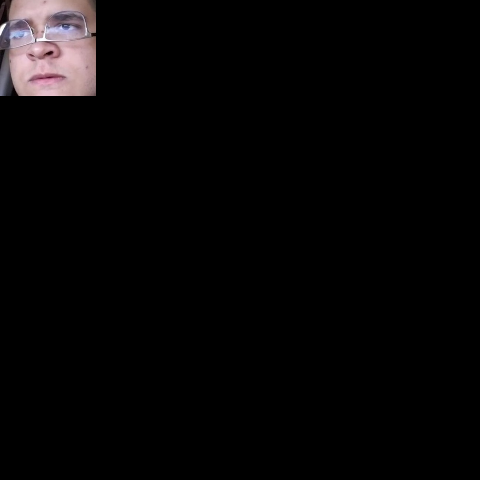

[INFO] faces for face ID: 36, qtd = 1


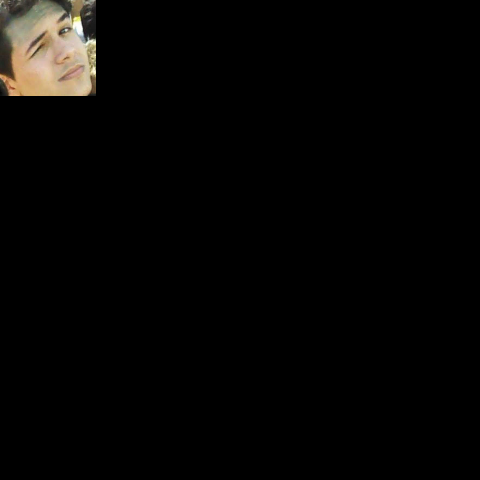

[INFO] faces for face ID: 37, qtd = 1


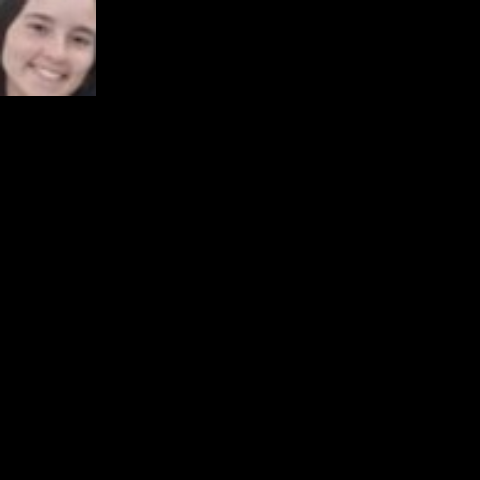

[INFO] faces for face ID: 38, qtd = 1


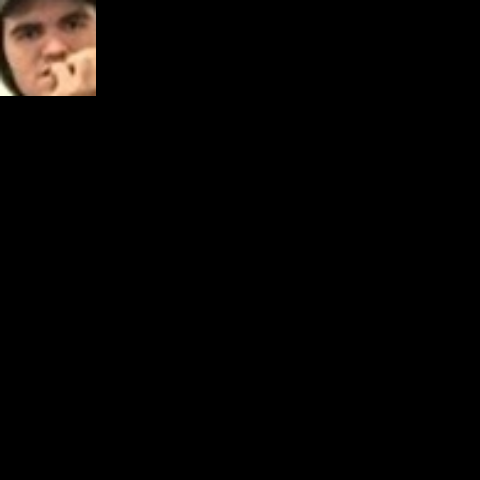

[INFO] faces for face ID: 39, qtd = 1


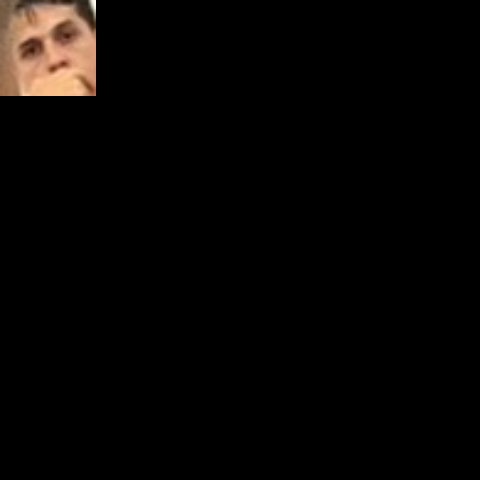

[INFO] faces for face ID: 40, qtd = 1


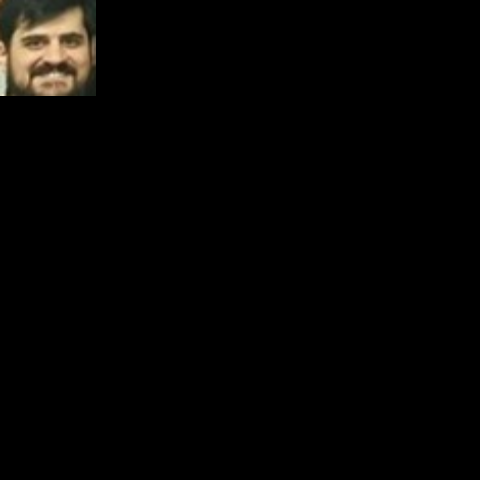

[INFO] faces for face ID: 41, qtd = 1


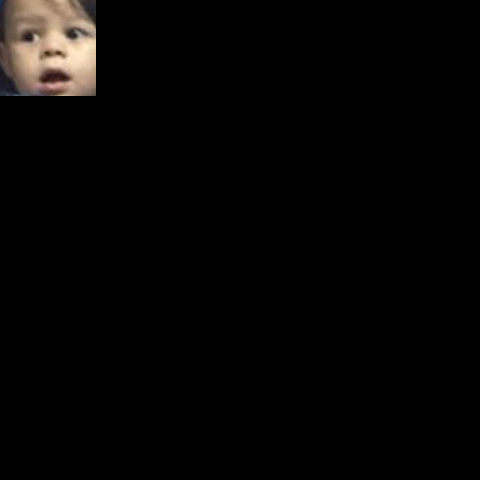

In [ ]:
for labelID in np.sort(df["cluster"].unique()):
  idxs = df[df["cluster"] == labelID]
  idx = idxs.sample(min(25, len(idxs)))

  print("[INFO] faces for face ID: {}, qtd = {}".format(labelID,len(idxs)))


  faces = []
  for i,line in idx.iterrows():
    image = cv2.imread(line["imagePath"])
    (top, right, bottom, left) = line["loc"]
    face = image[top:bottom, left:right]
    face = cv2.resize(face, (96, 96))
    faces.append(face)

  montage = build_montages(faces, (96, 96), (5, 5))[0]

	# show the output montage
  title = "Face ID #{}".format(labelID)
  title = "Unknown Faces" if labelID == -1 else title
  cv2_imshow(montage)


# Verificar se pessoa faz parte de um cluster


7
dataset/test/6.jpeg
dataset/test/7.jpeg
dataset/test/4.jpeg
dataset/test/2.jpg
dataset/test/3.jpeg
dataset/test/1.jpg
dataset/test/5.jpeg


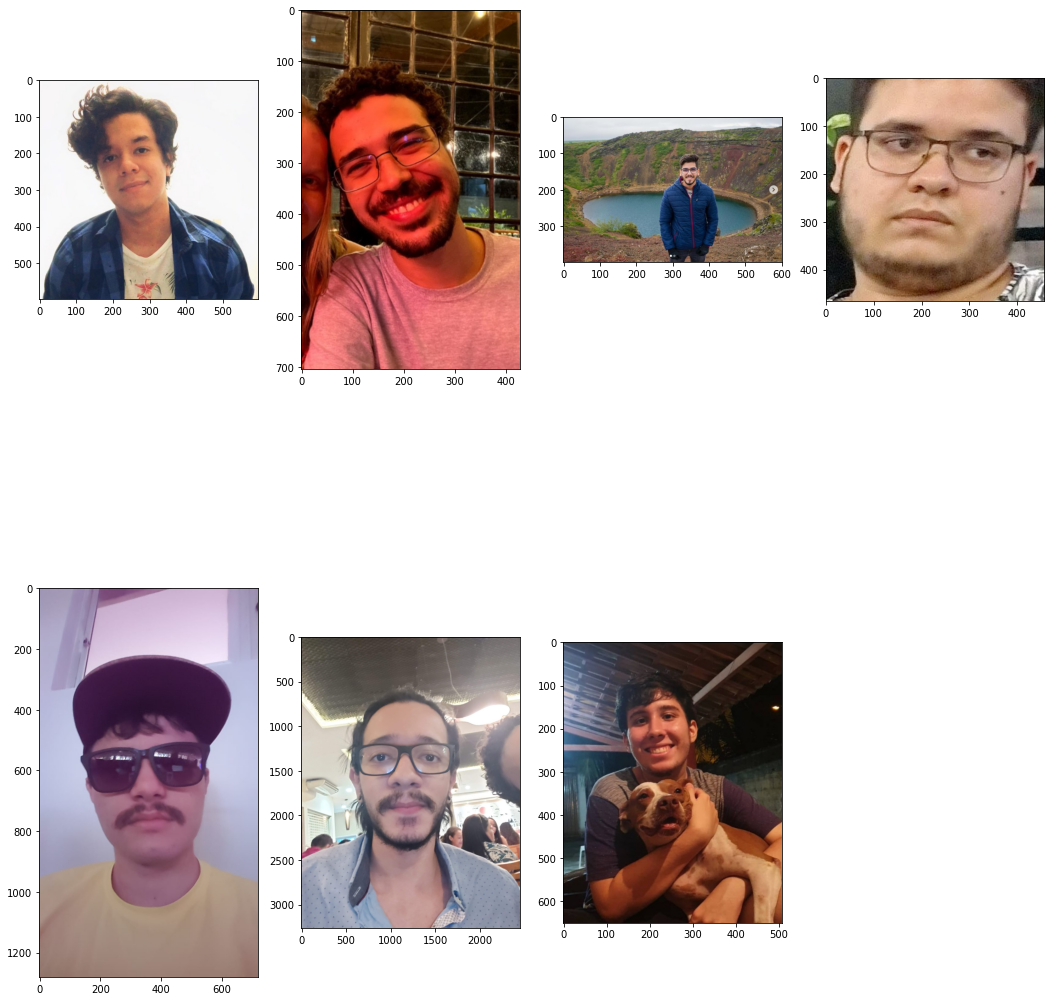

In [ ]:
plt.figure(figsize=(18,20))
plt.rcParams["axes.grid"] = False

print(len(images_path_test))

columns = 4
for i,line in enumerate(images_path_test):
    print(line)
    plt.subplot(int(len(images_path_test)/columns)+1,columns,i+1)
    img = cv2.imread(line)
    # cv2_imshow(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()

In [168]:
clusters_encodings = df[["encoding", "cluster"]].groupby("cluster")
clusters = df["cluster"].unique()

In [210]:
a = 3
it = [images_path_test[a]]
image_obj = cv2.imread(images_path_test[a])

test_encodings = extract_face_features(it,normalize= True, print_key = True)

val = 0
clust = None
thresh = 0.8
for cluster in clusters:
  cluster_encodings = clusters_encodings.get_group(cluster)["encoding"]
  value = face_recognition.face_distance(cluster_encodings.to_list(), test_encodings["encoding"].iloc[0])
  value =  np.max(value)
  if thresh <= value and value > val:
    clust = cluster
    val =  value

print(clust, val)

# aux = image_obj[15]
# (top, right, bottom, left) = test_encodings["loc"].loc[0]
# face = image_obj[top:bottom, left:right]
# cv2_imshow(face)


[INFO] processing dataset/test/2.jpg , 1/1
dataset/test/2.jpg
None 0


In [211]:
G_n, test_encodings_2  = add_new_faces(G, df, test_encodings)


In [ ]:
G_n[304]

AtlasView({10: {'value': 0.45598881994170964}, 11: {'value': 0.4495885610986327}, 12: {'value': 0.34266707976224836}, 15: {'value': 0.3922319384584139}, 121: {'value': 0.4921203522816876}, 122: {'value': 0.4246704367080712}, 202: {'value': 0.3908523047477962}, 214: {'value': 0.25406360243129916}, 228: {'value': 0.48856236569213707}, 235: {'value': 0.35277654300624506}, 244: {'value': 0.33587592598026994}, 254: {'value': 0.4836749701662265}, 295: {'value': 0.43704759888661593}})

# Test


In [ ]:
!git clone https://github.com/yl-1993/learn-to-cluster.git

Cloning into 'learn-to-cluster'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 1287 (delta 0), reused 1 (delta 0), pack-reused 1281
Receiving objects: 100% (1287/1287), 236.89 KiB | 6.77 MiB/s, done.
Resolving deltas: 100% (825/825), done.


In [ ]:
!cd learn-to-cluster
!sh scripts/vegcn/train_gcn_e_ms1m.sh
!cd ..

sh: 0: Can't open scripts/vegcn/train_gcn_e_ms1m.sh


ERROR: Could not find a version that satisfies the requirement swigfaiss (from versions: none)
ERROR: No matching distribution found for swigfaiss


In [ ]:
%cd learn-to-cluster
!pip install -r requirements.txt
!pip install faiss
%cd ..

/content/learn-to-cluster
     |████████████████████████████████| 256kB 5.7MB/s 
     |████████████████████████████████| 13.0MB 207kB/s 
     |████████████████████████████████| 3.2MB 31.1MB/s 
     |████████████████████████████████| 71kB 9.8MB/s 
     |████████████████████████████████| 163kB 46.0MB/s 
     |████████████████████████████████| 194kB 59.9MB/s 
     |████████████████████████████████| 194kB 50.1MB/s 
  Created wheel for mmcv: filename=mmcv-1.2.1-cp36-cp36m-linux_x86_64.whl size=418826 sha256=da6c883e7c1ec871453753b20bdcc07ae3489c3aa2a5aaaa1f31c8e0115101fd
  Stored in directory: /root/.cache/pip/wheels/16/e9/b3/7e073e39e40dc49f8807e48b95f50cdb53cf8ea4259ac8407b
  Created wheel for cairocffi: filename=cairocffi-1.2.0-cp36-none-any.whl size=89548 sha256=25f30d89c70b3d4cedfcbb14f49566ec240ab501899cdec09269b1ac63203ecd
  Stored in directory: /root/.cache/pip/wheels/40/76/48/f1effadceea83b32e7d957dd0f92db4db8b537d7b72b4ef374
Successfully built mmcv cairocffi
/content


In [ ]:
%cd learn-to-cluster
!sh scripts/vegcn/train_gcn_e_ms1m.sh
%cd ..


/content/learn-to-cluster
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/faiss/swigfaiss.py", line 14, in swig_import_helper
    return importlib.import_module(mname)
  File "/usr/lib/python3.6/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 994, in _gcd_import
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 955, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 658, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 571, in module_from_spec
  File "<frozen importlib._bootstrap_external>", line 922, in create_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
ImportError: libomp.so: cannot open shared object file: No such file or directory

During handling of the above exception, another exception occurred:

T